In [1]:
import requests
import json
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats as stats

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## This part is me replicating a paper that Ante posted a while ago in the chat

In [2]:
url = "https://api.nhle.com/stats/rest/en/game"
response = requests.get(url)
data = response.json()

In [3]:
df = pd.DataFrame(data['data'])
completed_games = df[(df['season'] >= 20152016) & (df['season'] <= 20222023)].copy()
completed_games.dropna(subset=['period'], inplace=True)


In [4]:
# Extract the unique list of teams and assign an integer label to each one
teams = completed_games.homeTeamId.unique()
teams = np.sort(teams)
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index

In [5]:
def add_team_data_labels(game_data):
    game_data = game_data.merge(teams, left_on='homeTeamId', right_on='team', how='left')
    game_data = game_data.rename(columns={'i': 'i_home'}).drop('team', axis=1)
    game_data = game_data.merge(teams, left_on='visitingTeamId', right_on='team', how='left')
    game_data = game_data.rename(columns={'i': 'i_away'}).drop('team', axis=1)

    
    return game_data
    
completed_games = add_team_data_labels(completed_games)

In [6]:
completed_games = completed_games[completed_games['homeTeamId'] <= 55]
num_teams = len(completed_games.i_home.drop_duplicates())
home_team = completed_games.i_home.values.astype(int)
away_team = completed_games.i_away.values.astype(int)
observed_home_goals = completed_games.homeScore.values
observed_away_goals = completed_games.visitingScore.values

In [9]:
with pm.Model() as model:
    # Global model parameters
    home = pm.Flat('home')
    sd_offence = pm.HalfStudentT('sd_offence', 3, 2.5)
    sd_defence = pm.HalfStudentT('sd_defence', 3, 2.5)
    intercept = pm.Flat('intercept')

    # Team-specific poisson model parameters
    offence_star = pm.Normal('offence_star', 0, sd_offence, shape=num_teams)
    defence_star = pm.Normal('defence_star', 0, sd_defence, shape=num_teams)
    offence = pm.Deterministic('offence', offence_star - pm.math.mean(offence_star))
    defence = pm.Deterministic('defence', defence_star - pm.math.mean(defence_star))
    home_theta = pm.math.exp(intercept + home + offence[home_team] - defence[away_team])
    away_theta = pm.math.exp(intercept + offence[away_team] - defence[home_team])

    # Likelihood of observed data
    home_goals = pm.Poisson('home_goals', mu=home_theta, observed=observed_home_goals)
    away_goals = pm.Poisson('away_goals', mu=away_theta, observed=observed_away_goals)


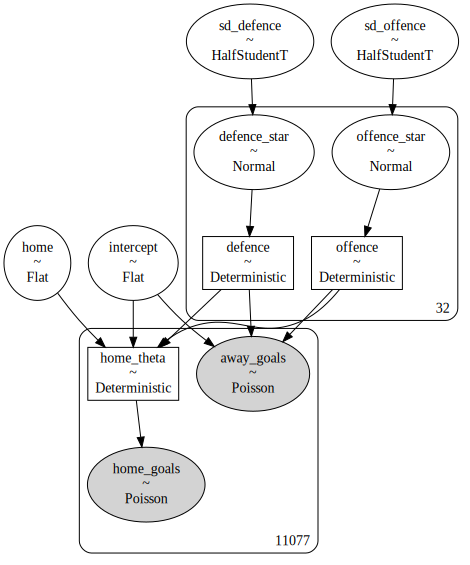

In [10]:
pm.model_to_graphviz(model)

In [8]:
with model:
    trace = pm.sample()
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home, sd_offence, sd_defence, intercept, offence_star, defence_star]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 218 seconds.


In [ ]:
zone_entry_factors_means = trace.posterior['zone_entry_factors'].mean(dim=('chain', 'draw'))

array([[<Axes: title={'center': 'home'}>,
        <Axes: title={'center': 'home'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'offence_star'}>,
        <Axes: title={'center': 'offence_star'}>],
       [<Axes: title={'center': 'defence_star'}>,
        <Axes: title={'center': 'defence_star'}>],
       [<Axes: title={'center': 'sd_offence'}>,
        <Axes: title={'center': 'sd_offence'}>],
       [<Axes: title={'center': 'sd_defence'}>,
        <Axes: title={'center': 'sd_defence'}>],
       [<Axes: title={'center': 'offence'}>,
        <Axes: title={'center': 'offence'}>],
       [<Axes: title={'center': 'defence'}>,
        <Axes: title={'center': 'defence'}>]], dtype=object)

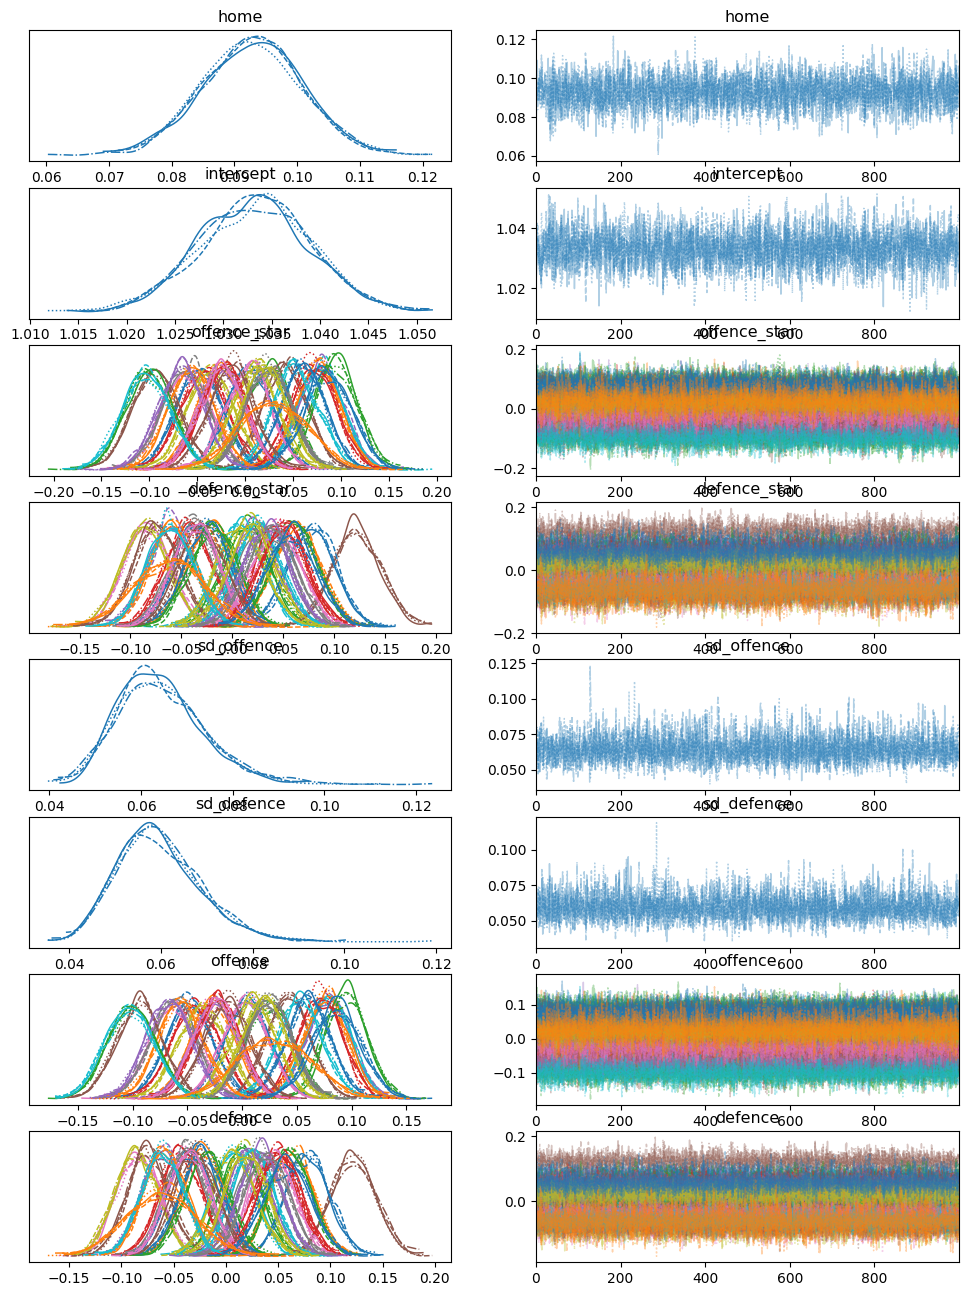

In [50]:
pm.plot_trace(trace)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

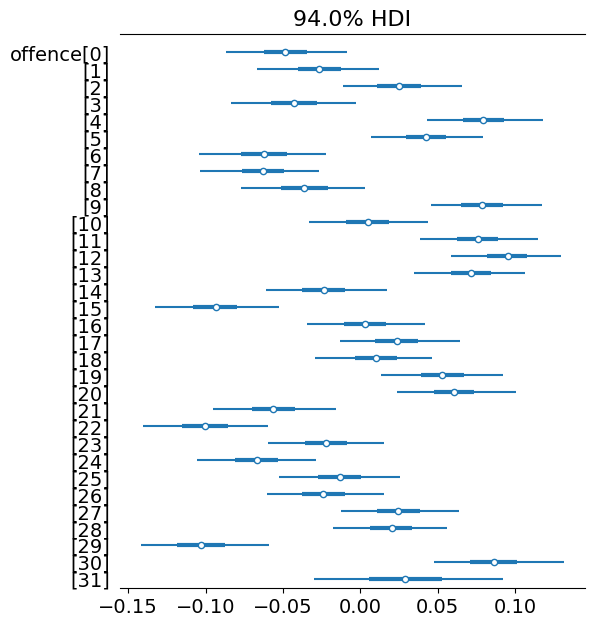

In [51]:
import arviz as az

# Assuming `trace` is your PyMC/ArviZ InferenceData object
az.plot_forest(trace, var_names=['offence'], kind='forestplot', hdi_prob=0.94, combined=True)


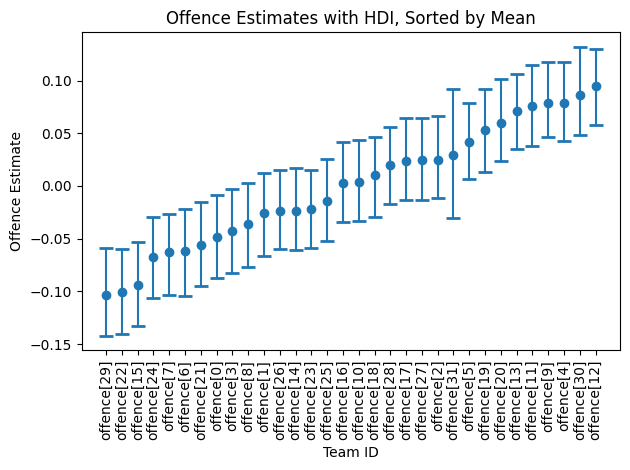

In [52]:
import matplotlib.pyplot as plt
import arviz as az
import numpy as np

# Calculate summary statistics
summary = az.summary(trace, var_names=['offence'], hdi_prob=0.94)

# Sort the summary by mean values
summary_sorted = summary.sort_values(by='mean')

# Extract means and HDI intervals after sorting
means = summary_sorted['mean']
hdi_lower = summary_sorted['hdi_3%']
hdi_upper = summary_sorted['hdi_97%']

# Calculate errors from mean to lower and upper bounds
errors = [means - hdi_lower, hdi_upper - means]

# Generate a sequence of team IDs or names based on the sorted order
# If teams.team.values is your original order, you might want to sort this array to match the sorted summary
# For demonstration, we'll use the index of the sorted summary, which corresponds to the sorted teams
team_ids = np.arange(len(means))

# Create error bars
plt.errorbar(team_ids, means, yerr=errors, fmt='o', capsize=5, capthick=2)

# Assuming you have a way to match sorted indices to team names or IDs, update the x-ticks to reflect the sorted order
# This example simply uses the sorted index; you may want to replace 'team_ids' with sorted team names or IDs
plt.xticks(team_ids, summary_sorted.index, rotation='vertical')  # Rotate labels for better readability

plt.xlabel('Team ID')
plt.ylabel('Offence Estimate')
plt.title('Offence Estimates with HDI, Sorted by Mean')
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()


## This is our project ~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [59]:
import requests
import json
import numpy as np
import pandas as pd
import pymc as pm

df = pd.read_csv('BDC_2024_Womens_Data.csv')

In [60]:
df['isin_ozone_for_home_team'] = False
df['isin_ozone_for_away_team'] = False
for idx, event in df.iterrows():
    if event['Home Team'] == event.Team:
        df.at[idx, 'isin_ozone_for_home_team'] = event["X Coordinate"] >= 123
        df.at[idx, 'isin_ozone_for_away_team'] = event["X Coordinate"] <= 75
    if event['Away Team'] == event.Team:
        df.at[idx, 'isin_ozone_for_away_team'] = event["X Coordinate"] >= 123
        df.at[idx, 'isin_ozone_for_home_team'] = event["X Coordinate"] <= 75

In [61]:
# Identify Zone Entry Events and their indices
zone_entry_indices = np.where(df['Event'].str.contains('Zone Entry'))

df['zone_entry_success'] = False  # Initialize the success column

for idx in zone_entry_indices[0]:
    entry_event = df.loc[idx]
    team = entry_event['Team']
    period = entry_event['Period']
    
    # Determine the correct isin_ozone column based on the team
    isin_ozone_col = 'isin_ozone_for_home_team' if team == entry_event['Home Team'] else 'isin_ozone_for_away_team'
    
    # Track subsequent events in the same period
    subsequent_events = df[(df.index > idx) & (df['Period'] == period)]
    
    # Initialize success as False
    entry_success = False
    
    for _, event in subsequent_events.iterrows():
        # Check if the event leaves the offensive zone
        if not event[isin_ozone_col]:
            break  # Exited the offensive zone without a shot/goal
        
        # Check for shot or goal before leaving the offensive zone
        if event['Team'] == team and event['Event'] in ['Shot', 'Goal']:
            entry_success = True
            break  # Found a shot/goal, mark success and stop checking
    
    # Assign success to the original zone entry event
    df.at[idx, 'zone_entry_success'] = entry_success


zone_entries = df[df['Event'].str.contains('Zone Entry')].copy()

In [62]:
import pandas as pd


players_positions = {
    'Blayre Turnbull': 'F',
    'Hilary Knight': 'F',
    'Sarah Fillier': 'F',
    'Hannah Bilka': 'F',
    'Brianne Jenner': 'F',
    'Alex Carpenter': 'F',
    'Natalie Buchbinder': 'D',
    'Jessie Eldridge': 'F',
    'Grace Zumwinkle': 'F',
    'Jamie Lee Rattray': 'F',
    'Emma Maltais': 'F',
    'Cayla Barnes': 'D',
    'Ashton Bell': 'D',
    'Emily Clark': 'F',
    'Haley Winn': 'D',
    'Abbey Murphy': 'F',
    'Sarah Nurse': 'F',
    'Megan Keller': 'D',
    'Lacey Eden': 'F',
    'Renata Fast': 'D',
    'Laura Stacey': 'F',
    'Julia Gosling': 'F',
    'Jamie Bourbonnais': 'D',
    'Tessa Janecke': 'F',
    'Abby Roque': 'F',
    'Taylor Heise': 'F',
    'Ella Shelton': 'D',
    'Savannah Harmon': 'D',
    'Marie-Philip Poulin': 'F',
    'Hayley Scamurra': 'F',
    'Gabbie Hughes': 'F',
    'Jessica DiGirolamo': 'D',
    "Kristin O'Neill": 'F',
    'Erin Ambrose': 'D',
    'Britta Curl': 'F',
    'Kelly Pannek': 'F',
    'Jocelyne Larocque': 'D',
    'Rory Guilday': 'D',
    'Sophie Jaques': 'D',
    'Laila Edwards': 'F',
    'Jennifer Gardiner': 'F',
    'Caroline Harvey': 'D',
    'Loren Gabel': 'F',
    'Kirsten Simms': 'F',
    'Danielle Serdachny': 'F',
    'Anna Wilgren': 'D',
    'Anne Cherkowski': 'F',
    'Allyson Simpson': 'D'
}


df_players_positions = pd.DataFrame(list(players_positions.items()), columns=['Player', 'Position'])
df_players_positions['is_forward'] = df_players_positions['Position'].apply(lambda x: x == 'F')
zone_entries = zone_entries.merge(df_players_positions, left_on='Player', right_on='Player', how='left')

In [63]:
zone_entries['Entry_Type'] = pd.Categorical(zone_entries['Detail 1'])
zone_entries['Game'] = pd.Categorical(zone_entries['Date'])
dummies = pd.get_dummies(zone_entries['Entry_Type'], drop_first=True)  # Use one-hot encoding, drop_first to avoid dummy variable trap
zone_entries = pd.concat([zone_entries, dummies], axis=1)
zone_entries.to_csv('zone_entries.csv', index=False)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, coeffs]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


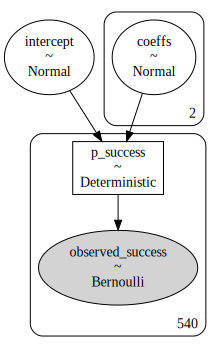

In [11]:
import pymc as pm

with pm.Model() as model:
    # Priors for the intercept and coefficients
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    coeffs = pm.Normal('coeffs', mu=0, sigma=10, shape=len(dummies.columns))
    
    # Logistic regression
    logits = intercept + pm.math.dot(dummies.values, coeffs)
    p_success = pm.Deterministic('p_success', pm.math.sigmoid(logits))
    
    # Likelihood
    observed_success = pm.Bernoulli('observed_success', p=p_success, observed=zone_entries['zone_entry_success'].values)
    
    # Sampling
    trace = pm.sample()

pm.model_to_graphviz(model)

array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'coeffs'}>,
        <Axes: title={'center': 'coeffs'}>],
       [<Axes: title={'center': 'p_success'}>,
        <Axes: title={'center': 'p_success'}>]], dtype=object)

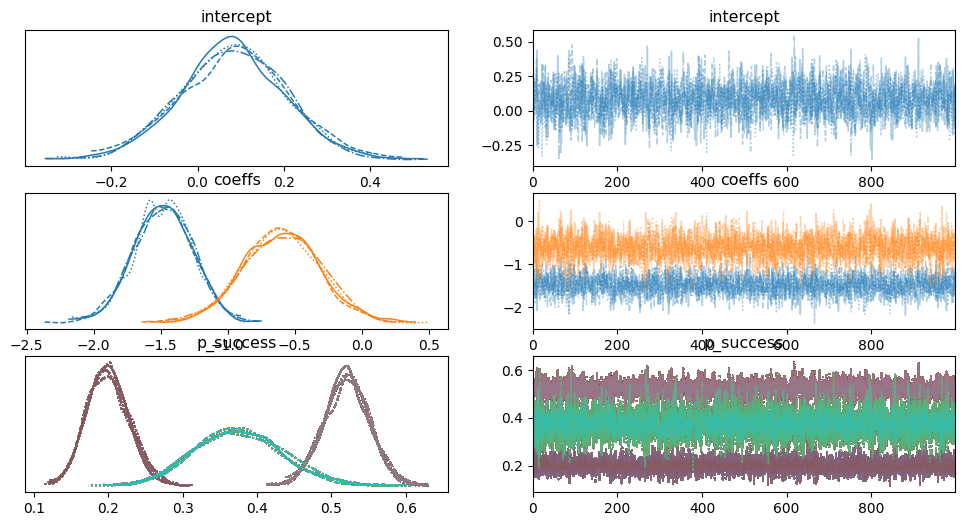

In [58]:
import arviz as az
az.plot_trace(trace)

In [12]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.086,0.124,-0.140,0.322,0.003,0.002,1922.0,2636.0,1.0
coeffs[0],-1.488,0.212,-1.874,-1.098,0.004,0.003,2341.0,2799.0,1.0
coeffs[1],-0.613,0.280,-1.120,-0.074,0.005,0.004,2723.0,2814.0,1.0
p_success[0],0.521,0.031,0.465,0.580,0.001,0.000,1922.0,2636.0,1.0
p_success[1],0.199,0.027,0.149,0.250,0.000,0.000,4437.0,3196.0,1.0
...,...,...,...,...,...,...,...,...,...
p_success[535],0.521,0.031,0.465,0.580,0.001,0.000,1922.0,2636.0,1.0
p_success[536],0.521,0.031,0.465,0.580,0.001,0.000,1922.0,2636.0,1.0
p_success[537],0.521,0.031,0.465,0.580,0.001,0.000,1922.0,2636.0,1.0
p_success[538],0.373,0.058,0.262,0.480,0.001,0.001,4205.0,3286.0,1.0


In [59]:
# Map the entry types to numeric codes for modeling
entry_type_mapping = {'Carried': 0, 'Dumped': 1, 'Played': 2}
zone_entries['Entry Type Code'] = zone_entries['Detail 1'].map(entry_type_mapping)

# Ensure the mapping is correctly applied
zone_entries[['Detail 1', 'Entry Type Code']].head()


,Detail 1,Entry Type Code
13,Carried,0
20,Dumped,1
24,Carried,0
39,Played,2
43,Carried,0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coeffs]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


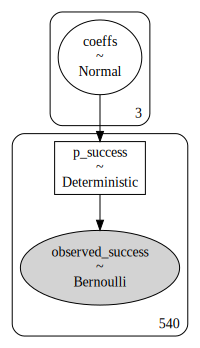

In [63]:
import pymc as pm
import numpy as np

n_entry_types = len(entry_type_mapping)  # Number of entry types

with pm.Model() as model:
    # Priors for the intercept and coefficients for each entry type
    #intercept = pm.Normal('intercept', mu=0, sigma=10)
    coeffs = pm.Normal('coeffs', mu=0, sigma=10, shape=n_entry_types)  # One coefficient per entry type
    
    # Index coefficients based on the entry type code
    entry_type_index = zone_entries['Entry Type Code'].values
    logits = coeffs[entry_type_index]  # This selects the right coefficient based on entry type intercept + 
    
    p_success = pm.Deterministic('p_success', pm.math.sigmoid(logits))
    
    # Likelihood
    observed_success = pm.Bernoulli('observed_success', p=p_success, observed=zone_entries['zone_entry_success'].values)
    
    # Sampling
    trace = pm.sample()

pm.model_to_graphviz(model)


array([[<Axes: title={'center': 'coeffs'}>,
        <Axes: title={'center': 'coeffs'}>],
       [<Axes: title={'center': 'p_success'}>,
        <Axes: title={'center': 'p_success'}>]], dtype=object)

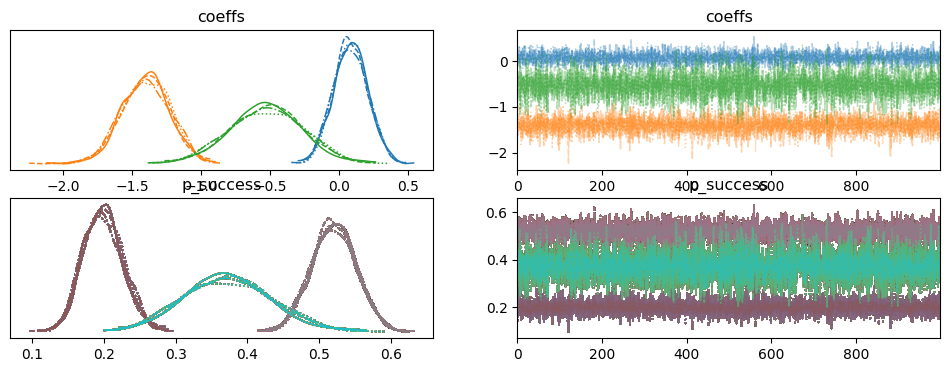

In [64]:
az.plot_trace(trace)

In [62]:
zone_entries[zone_entries['Detail 1'] == 'Dumped']['zone_entry_success'].mean()


0.19902912621359223

# Random effects model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, coeffs, sigma_games, game_effects]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.


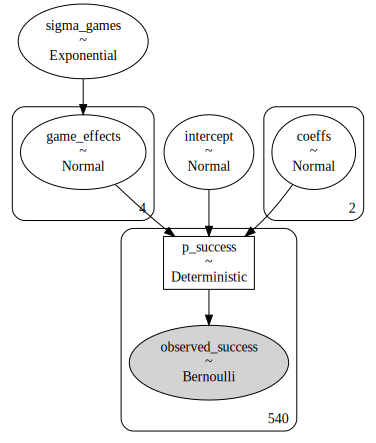

In [17]:
import pymc as pm
import numpy as np

period_ids = zone_entries['Period'].astype('category').cat.codes.values
game_ids = zone_entries['Date'].astype('category').cat.codes.values
n_games = len(np.unique(game_ids))
n_periods = len(np.unique(period_ids))
with pm.Model() as model:
    # Priors for the intercept and coefficients
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    coeffs = pm.Normal('coeffs', mu=0, sigma=10, shape=len(dummies.columns))
    
    # Priors for the game-specific random effects
    sigma_games = pm.Exponential('sigma_games', 1)  # Variance of game effects
    game_effects = pm.Normal('game_effects', mu=0, sigma=sigma_games, shape=n_games)
    
    # Logistic regression with game random effects
    logits = intercept + pm.math.dot(dummies.values, coeffs) + game_effects[game_ids]
    p_success = pm.Deterministic('p_success', pm.math.sigmoid(logits))
    
    # Likelihood
    observed_success = pm.Bernoulli('observed_success', p=p_success, observed=zone_entries['zone_entry_success'].values)
    
    # Sampling
    trace_RE = pm.sample()

pm.model_to_graphviz(model)


In [24]:
period_ids = zone_entries['Period'].astype('category').cat.codes.values
n_periods = len(np.unique(period_ids))

with pm.Model() as model:
    # Priors for the intercept and coefficients
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    coeffs = pm.Normal('coeffs', mu=0, sigma=10, shape=len(dummies.columns))
    
    # Priors for the game-specific random effects
    sigma_games = pm.Exponential('sigma_games', 1)  # Variance of game effects
    period_effects = pm.Normal('period_effects', mu=0, sigma=sigma_games, shape=n_periods)
    
    # Logistic regression with game random effects
    logits = intercept + pm.math.dot(dummies.values, coeffs) + period_effects[period_ids]
    p_success = pm.Deterministic('p_success', pm.math.sigmoid(logits))
    
    # Likelihood
    observed_success = pm.Bernoulli('observed_success', p=p_success, observed=zone_entries['zone_entry_success'].values)
    
    # Sampling
    trace_RE_period = pm.sample()



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, coeffs, sigma_games, period_effects]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'coeffs'}>,
        <Axes: title={'center': 'coeffs'}>],
       [<Axes: title={'center': 'game_effects'}>,
        <Axes: title={'center': 'game_effects'}>],
       [<Axes: title={'center': 'sigma_games'}>,
        <Axes: title={'center': 'sigma_games'}>],
       [<Axes: title={'center': 'p_success'}>,
        <Axes: title={'center': 'p_success'}>]], dtype=object)

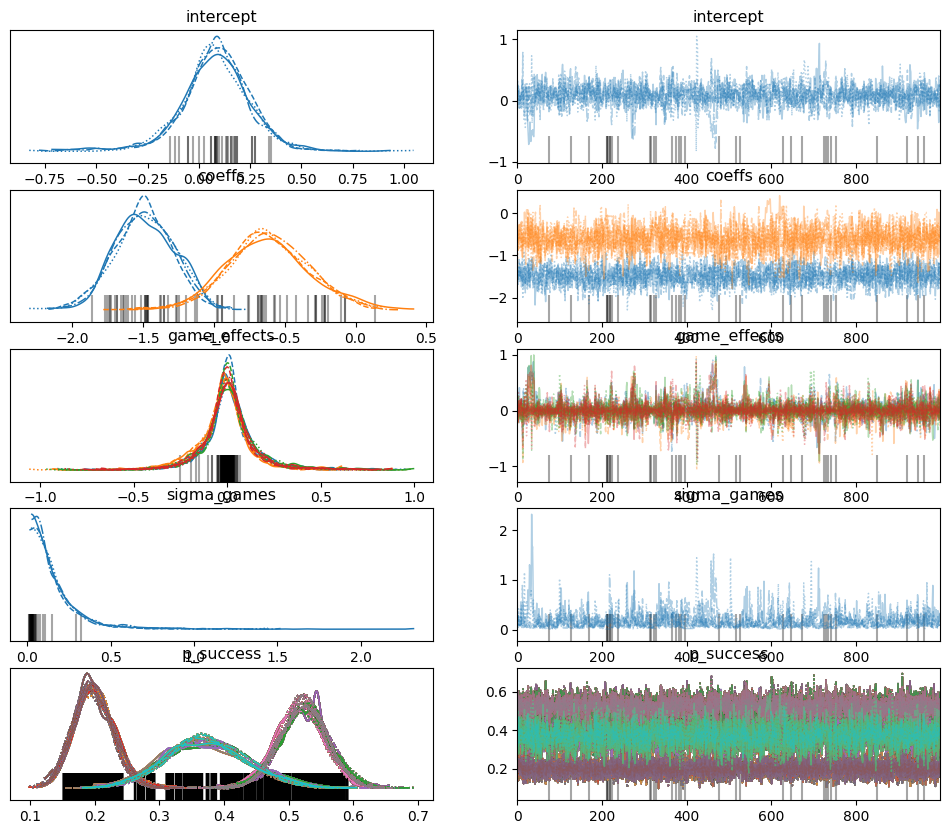

In [21]:
import arviz as az
az.plot_trace(trace_RE)

In [22]:
az.summary(trace_RE, var_names=['game_effects'], hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
game_effects[0],0.013,0.146,-0.269,0.278,0.005,0.004,1333.0,751.0,1.0
game_effects[1],-0.020,0.147,-0.315,0.253,0.004,0.003,1548.0,907.0,1.0
game_effects[2],0.016,0.148,-0.280,0.300,0.005,0.004,1448.0,747.0,1.0
game_effects[3],0.006,0.146,-0.287,0.273,0.005,0.004,1337.0,802.0,1.0


In [28]:
az.summary(trace_RE, var_names=['sigma_games'], hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_games,0.164,0.165,0.011,0.421,0.007,0.005,403.0,466.0,1.0


array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'coeffs'}>,
        <Axes: title={'center': 'coeffs'}>],
       [<Axes: title={'center': 'period_effects'}>,
        <Axes: title={'center': 'period_effects'}>],
       [<Axes: title={'center': 'sigma_games'}>,
        <Axes: title={'center': 'sigma_games'}>],
       [<Axes: title={'center': 'p_success'}>,
        <Axes: title={'center': 'p_success'}>]], dtype=object)

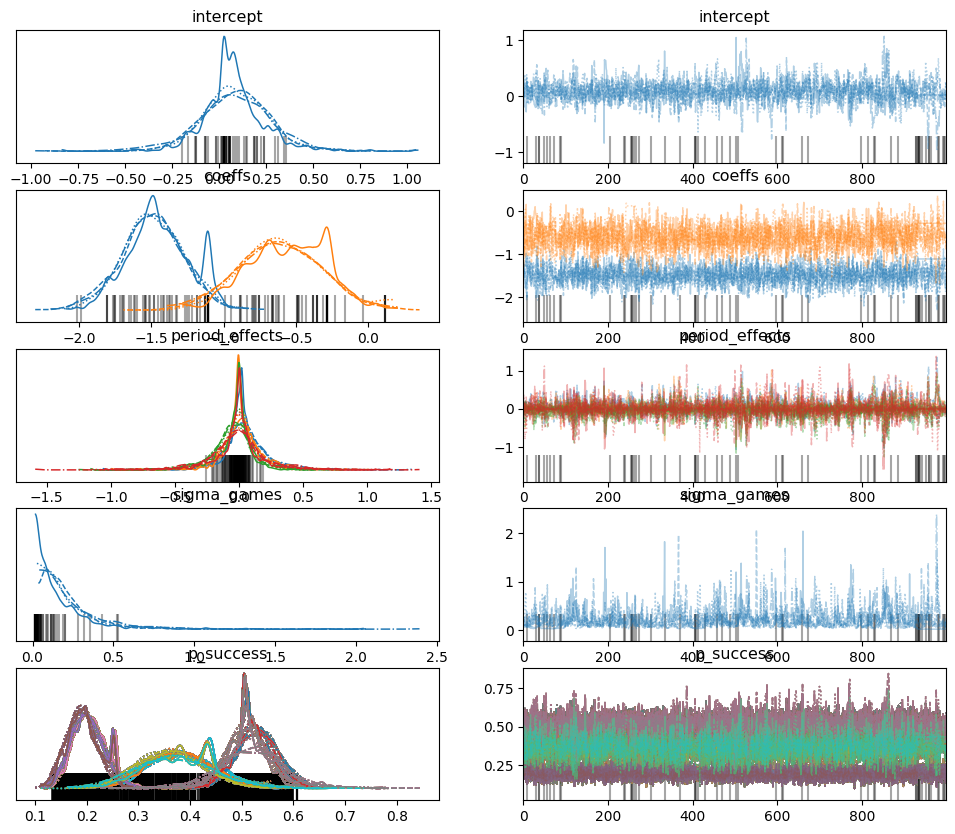

In [25]:
import arviz as az
az.plot_trace(trace_RE_period)

In [27]:
az.summary(trace_RE_period, var_names=['period_effects'], hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
period_effects[0],0.041,0.173,-0.276,0.399,0.005,0.004,1518.0,1293.0,1.02
period_effects[1],0.014,0.166,-0.298,0.343,0.004,0.004,1708.0,1337.0,1.02
period_effects[2],-0.052,0.167,-0.405,0.245,0.005,0.004,1453.0,1236.0,1.01
period_effects[3],-0.007,0.225,-0.439,0.452,0.005,0.005,2550.0,1473.0,1.02


In [29]:
az.summary(trace_RE_period, var_names=['sigma_games'], hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_games,0.208,0.203,0.016,0.528,0.009,0.006,107.0,72.0,1.03


In [70]:
player_ids = zone_entries['Player'].astype('category').cat.codes.values
n_players = len(np.unique(player_ids))

with pm.Model() as model:
    # Priors for the intercept and coefficients
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    coeffs = pm.Normal('coeffs', mu=0, sigma=10, shape=len(dummies.columns))
    
    # Priors for the player-specific random effects
    sigma_players = pm.Exponential('sigma_players', 1)  # Variance of player effects
    player_effects = pm.Normal('player_effects', mu=0, sigma=sigma_players, shape=n_players)
    
    # Logistic regression with player random effects
    logits = intercept + pm.math.dot(dummies.values, coeffs) + player_effects[player_ids]
    p_success = pm.Deterministic('p_success', pm.math.sigmoid(logits))
    
    # Likelihood
    observed_success = pm.Bernoulli('observed_success', p=p_success, observed=zone_entries['zone_entry_success'].values)
    
    # Sampling
    trace_RE_players = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, coeffs, sigma_players, player_effects]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 96 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 188 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'coeffs'}>,
        <Axes: title={'center': 'coeffs'}>],
       [<Axes: title={'center': 'player_effects'}>,
        <Axes: title={'center': 'player_effects'}>],
       [<Axes: title={'center': 'sigma_players'}>,
        <Axes: title={'center': 'sigma_players'}>],
       [<Axes: title={'center': 'p_success'}>,
        <Axes: title={'center': 'p_success'}>]], dtype=object)

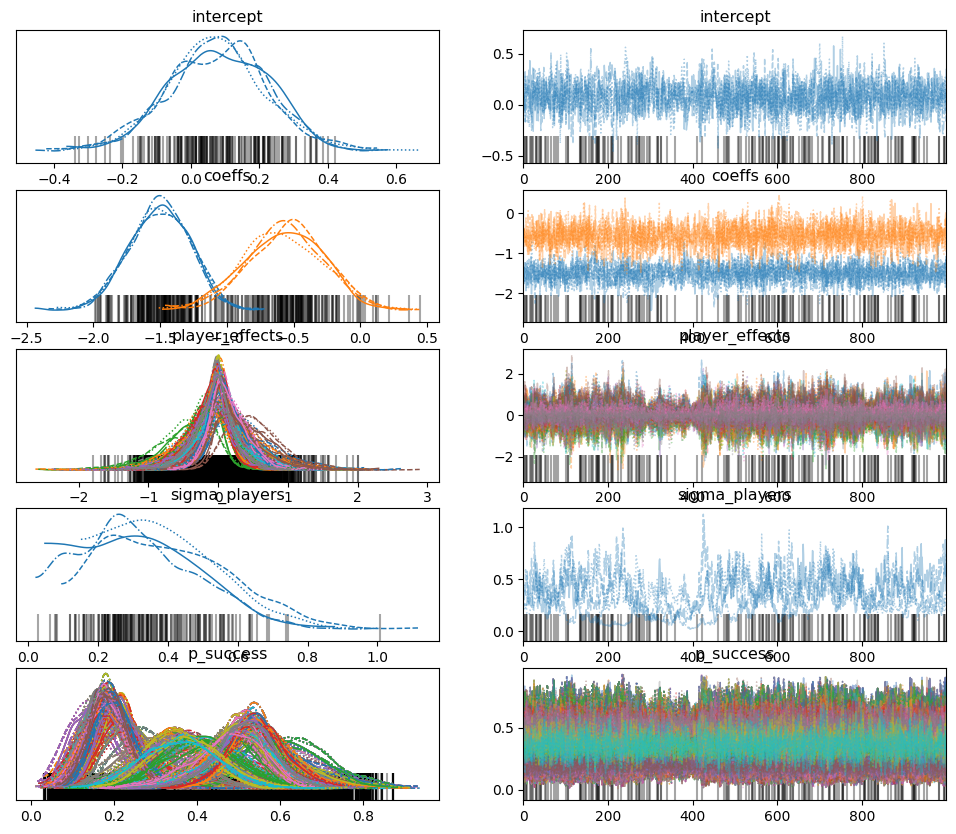

In [71]:
import arviz as az
az.plot_trace(trace_RE_players)

In [72]:
az.summary(trace_RE_players, var_names=['player_effects'], hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
player_effects[0],-0.044,0.287,-0.621,0.487,0.004,0.009,4602.0,1707.0,1.03
player_effects[1],0.114,0.280,-0.408,0.679,0.007,0.008,2006.0,1660.0,1.02
player_effects[2],0.001,0.278,-0.530,0.540,0.004,0.007,5035.0,1971.0,1.03
player_effects[3],0.029,0.379,-0.700,0.761,0.006,0.011,4128.0,1240.0,1.02
player_effects[4],0.090,0.380,-0.615,0.854,0.008,0.012,2448.0,1222.0,1.02
player_effects[5],0.113,0.367,-0.507,0.906,0.008,0.010,2892.0,1607.0,1.02
player_effects[6],0.101,0.327,-0.496,0.760,0.006,0.010,3950.0,1453.0,1.02
player_effects[7],-0.076,0.285,-0.682,0.443,0.004,0.010,4126.0,1891.0,1.03
player_effects[8],0.050,0.290,-0.495,0.615,0.005,0.009,3618.0,1742.0,1.02
player_effects[9],-0.079,0.324,-0.724,0.509,0.006,0.009,3125.0,1233.0,1.02


In [73]:
az.summary(trace_RE_players, var_names=['sigma_players'], hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_players,0.353,0.172,0.055,0.653,0.031,0.022,26.0,45.0,1.11


In [38]:
az.summary(trace_RE_players, var_names=['p_success'], hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p_success[0],0.502,0.072,0.360,0.633,0.001,0.001,4382.0,2453.0,1.00
p_success[1],0.171,0.045,0.089,0.256,0.001,0.001,1180.0,1740.0,1.01
p_success[2],0.490,0.085,0.321,0.646,0.002,0.001,2408.0,2102.0,1.00
p_success[3],0.340,0.092,0.162,0.499,0.002,0.002,1575.0,2038.0,1.01
p_success[4],0.532,0.077,0.389,0.676,0.001,0.001,4710.0,2442.0,1.01
...,...,...,...,...,...,...,...,...,...
p_success[535],0.467,0.088,0.291,0.621,0.003,0.002,1147.0,1534.0,1.01
p_success[536],0.467,0.088,0.291,0.621,0.003,0.002,1147.0,1534.0,1.01
p_success[537],0.514,0.075,0.370,0.650,0.001,0.001,4595.0,1970.0,1.00
p_success[538],0.382,0.088,0.212,0.537,0.001,0.001,4508.0,3134.0,1.00


In [74]:
az.summary(trace_RE_players, var_names=['coeffs'], hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
coeffs[0],-1.504,0.229,-1.952,-1.113,0.006,0.004,1649.0,1708.0,1.0
coeffs[1],-0.564,0.297,-1.141,-0.033,0.007,0.005,1933.0,1902.0,1.0
